# 사례를 통해서 배우는 파생 변수 만들기 1편

## 실습 개요

사례를 통해서 배우는 파생 변수 만들기 1편


1) 실습 목적
 * 실제 주가 데이터셋(OHLCV)을 통해서 파생 변수를 만들어 보는 실습을 진행합니다.
 * 금융 & 주식 도메인에서의 전문적인 파생 변수를 알아봅니다.


2) 수강 목표
 * 금융 & 주식 도메인에서의 파생 변수인 이동평균, 볼린저 밴드, MACD 등을 이해할 수 있습니다.
 * 파생 변수가 알고리즘 모델에 미치는 영향을 이해할 수 있습니다.


### 실습 목차
* **1. 주가(OHLCV) 데이터셋 실습 해보기**
  * 실습 데이터 재구성하기
  * 시계열 데이터란?
  * 파생 변수 만들기I (도메인 지식 기반)
  * 파생 변수 만들기II (상장법인정보 기반)
  * 데이터 인코딩 및 결측치 정리


###  데이터셋 개요

* 데이터셋: Yahoo Finance OHLCV 데이터셋이란? (Open High Close Low Volume)
* 데이터셋 개요 : **Yahoo Finance는 주식, 환율과 같은 금융 정보를 제공하는 플랫폼입니다.** 주식과 관련된 정보 및 시각화 정보를 웹사이트를 통해서 제공 (NASDAQ, KOSPI, NIKKEI 등) 됩니다. 데이터는 무료로 사용할 수 있으며, API를 제공하여 손쉽게 데이터를 수집 가능합니다. 또한, Yahoo Finance 정보를 랩핑한 yfinance 패키지를 이용해 파이썬에서도 사용 가능합니다.
  - (O)pen (시가): 주식의 거래가 시작된 가격을 나타냅니다. 시장이 열리면 처음으로 발생한 거래의 가격입니다.
  - (H)igh (고가): 특정 기간 동안 주식의 가격 중 최고점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 높게 거래되었는지를 보여줍니다.
  - (C)lose (종가): 주식의 거래가 마감된 가격을 나타냅니다. 시장이 닫힐 때 주식이 어떤 가격으로 거래를 마쳤는지를 보여줍니다.
  - (L)ow (저가): 특정 기간 동안 주식의 가격 중 최저점을 나타냅니다. 이는 해당 기간 동안 주식이 얼마나 낮게 거래되었는지를 보여줍니다.
  - (V)Volume (거래량):  특정 기간 동안 거래된 주식의 총 수량을 나타냅니다. 거래량은 주식 시장에서 매우 중요한 지표 중 하나이며, 주식의 유동성과 관련이 있습니다. 더 높은 거래량은 주식 시장의 활발한 거래를 나타낼 수 있습니다.
  - Change (변동률): 이전 주가와 비교해 변화된 변동률 입니다.
  - code (종목 코드): 종목(회사)를 구분하는 코드입니다.
* 데이터셋 저작권 : Apache Software License (Apache)

### 환경 설정
- **패키지 설치 및 임포트**


In [152]:
!uv add mplfinance

Resolved 174 packages in 12ms
Audited 69 packages in 8ms


In [153]:
# 표준 라이브러리
import os
import time
import warnings

# 수치 계산
import numpy as np
import pandas as pd

# 데이터 수집 (한국 주식 OHLCV)
from pykrx import stock as pykrx_stock

# 시각화
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates
import seaborn as sns
from IPython.display import display
from mplfinance.original_flavor import candlestick_ohlc

# 전처리 및 평가
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 경고 무시
warnings.filterwarnings(action='ignore')

## 1. 주가(OHLCV) 데이터셋 실습 해보기

```
💡 목차 개요 : 실제 주가 데이터셋을 통해 파생 변수를 제작해보고, 직접 알고리즘 모델로 학습을 진행합니다.  
```
- **1-1 실습 데이터 재구성하기**
- **1-2 시계열 데이터란?**
- **1-3 파생 변수 만들기I (도메인 지식 기반)**
- **1-4 파생 변수 만들기II (상장법인정보 기반)**
- **1-5 데이터 인코딩 및 결측치 정리**


### 1-1 실습 데이터 재구성하기



#### 📝 설명 : (1-1)
> OHLCV 데이터셋의 크기가 방대하고, 학습 모델에 적절치 않기 때문에 실습전에 데이터셋을 재구성 하도록 하겠습니다.
1. **OHLCV 데이터셋의 날짜 범위를 2020년 1월에서 2023년 7월 사이로 축소하도록 하겠습니다.**
2. **실습을 위해서는 정답(레이블) 컬럼을 구성해야합니다. 다음날 종가(Close)를 정답 컬럼으로 만들겠습니다.**

#### 👨‍💻 코드 : (1-1)


In [154]:
# 데이터 저장 경로 설정 (노트북이 있는 디렉토리 기준)
DATA_DIR = os.path.join(os.getcwd(), "data")
print(f"데이터 디렉토리: {DATA_DIR}")

데이터 디렉토리: /Users/tylersong/Desktop/workspace/learn/python/offline/TIL/ml/data


#### 📥 Yahoo Finance OHLCV 데이터 수집 및 저장
> pykrx 패키지를 활용하여 한국 주식(KOSPI) OHLCV 데이터를 수집하고 parquet 파일로 저장합니다.
> - **OHLCV.parquet**: 주가 데이터 (시가, 고가, 저가, 종가, 거래량, 변동률)
> - **Company.parquet**: 상장법인 정보 (회사명, 업종, 주요제품, 상장일 등)
>
> 이미 파일이 존재하면 다운로드를 건너뜁니다.

In [155]:
# ============================================================
# 주요 KOSPI 종목 메타 정보 정의
# (회사명, 업종, 주요제품, 상장일, 결산월, 지역)
# ============================================================
STOCK_META = {
    "005930": ("삼성전자", "반도체 제조업", "메모리반도체, 시스템LSI", "1975-06-11", "12월", "경기"),
    "000660": ("SK하이닉스", "반도체 제조업", "DRAM, NAND Flash", "1996-12-26", "12월", "경기"),
    "035420": ("NAVER", "소프트웨어 개발업", "인터넷 검색, 커머스", "2008-11-28", "12월", "경기"),
    "035720": ("카카오", "소프트웨어 개발업", "메신저, 포털 서비스", "2017-07-10", "12월", "제주"),
    "005380": ("현대자동차", "자동차 제조업", "자동차, 차량부품", "1974-06-28", "12월", "서울"),
    "000270": ("기아", "자동차 제조업", "자동차, 차량부품", "1973-07-21", "12월", "서울"),
    "051910": ("LG화학", "기초화학물질 제조업", "석유화학, 첨단소재", "2001-04-25", "12월", "서울"),
    "006400": ("삼성SDI", "일차전지 및 축전지 제조업", "이차전지, 전자재료", "1979-03-09", "12월", "경기"),
    "207940": ("삼성바이오로직스", "의약품 제조업", "바이오의약품 위탁생산", "2016-11-10", "12월", "인천"),
    "068270": ("셀트리온", "의약품 제조업", "바이오시밀러 의약품", "2008-09-23", "12월", "인천"),
    "105560": ("KB금융", "금융 지주회사", "은행, 증권, 보험", "2008-10-10", "12월", "서울"),
    "055550": ("신한지주", "금융 지주회사", "은행, 증권, 카드", "2001-09-10", "12월", "서울"),
    "005490": ("POSCO홀딩스", "철강 제조업", "철강제품, 신소재", "1988-06-10", "12월", "서울"),
    "015760": ("한국전력", "전기업", "전력자원 개발 및 발전", "1989-08-10", "12월", "전남"),
    "017670": ("SK텔레콤", "전기통신업", "이동통신 서비스", "1989-03-20", "12월", "서울"),
    "030200": ("KT", "전기통신업", "유무선 통신 서비스", "2002-12-18", "12월", "경기"),
    "066570": ("LG전자", "가정용 기기 제조업", "가전, TV, 전장부품", "2002-04-22", "12월", "서울"),
    "028260": ("삼성물산", "종합건설업", "건설, 상사, 리조트", "2015-09-15", "12월", "서울"),
    "032830": ("삼성생명", "생명보험업", "생명보험, 자산운용", "2010-05-12", "12월", "서울"),
    "012330": ("현대모비스", "자동차 부품 제조업", "자동차 모듈, 부품", "1989-07-25", "12월", "서울"),
    "096770": ("SK이노베이션", "석유정제업", "석유정제, 배터리", "2007-07-25", "12월", "서울"),
    "034730": ("SK", "지주회사", "지주사업, 투자사업", "1991-12-17", "12월", "서울"),
    "003550": ("LG", "지주회사", "지주사업, 투자사업", "2003-04-24", "12월", "서울"),
    "000810": ("삼성화재", "손해보험업", "손해보험, 자산운용", "1975-06-30", "12월", "서울"),
    "009150": ("삼성전기", "전자부품 제조업", "MLCC, 카메라모듈", "1979-03-10", "12월", "경기"),
    "086790": ("하나금융지주", "금융 지주회사", "은행, 증권, 보험", "2005-12-01", "12월", "서울"),
    "316140": ("우리금융지주", "금융 지주회사", "은행, 카드, 캐피탈", "2019-01-11", "12월", "서울"),
    "010130": ("고려아연", "비철금속 제련업", "아연, 연, 금, 은", "1990-03-08", "12월", "서울"),
    "097950": ("CJ제일제당", "식품 제조업", "식품, 바이오", "2007-09-05", "12월", "서울"),
    "003670": ("포스코퓨처엠", "일차전지 및 축전지 제조업", "양극재, 음극재", "2003-04-22", "12월", "경북"),
    "352820": ("하이브", "음악 및 기타 오디오물 출판업", "음악 기획, 제작", "2020-10-15", "12월", "서울"),
    "000100": ("유한양행", "의약품 제조업", "의약품, 건강기능식품", "1962-11-01", "12월", "서울"),
    "011170": ("롯데케미칼", "기초화학물질 제조업", "석유화학제품", "1976-12-01", "12월", "서울"),
    "032640": ("LG유플러스", "전기통신업", "이동통신, IPTV", "2000-07-27", "12월", "서울"),
    "139480": ("이마트", "종합 소매업", "대형마트, 온라인쇼핑", "2011-06-10", "12월", "서울"),
}

print(f"수집 대상: {len(STOCK_META)}개 종목")

수집 대상: 35개 종목


In [156]:
# ============================================================
# OHLCV 데이터 수집 및 parquet 파일 대신 CSV 파일로 저장
# ============================================================
OHLCV_PATH = os.path.join(DATA_DIR, "OHLCV.csv")
COMPANY_PATH = os.path.join(DATA_DIR, "Company.csv")

# pykrx 컬럼명 → 영문 컬럼명 매핑
COLUMN_MAP = {
    "시가": "Open", "고가": "High", "저가": "Low",
    "종가": "Close", "거래량": "Volume", "등락률": "Change",
}
 
if os.path.exists(OHLCV_PATH) and os.path.exists(COMPANY_PATH):
    print("✅ 데이터 파일이 이미 존재합니다. 다운로드를 건너뜁니다.")
    print(f"   - {OHLCV_PATH}")
    print(f"   - {COMPANY_PATH}")
else:
    print("📥 pykrx를 통해 KOSPI OHLCV 데이터를 수집합니다...")
    print("   (약 1~2분 소요될 수 있습니다)\n")

    codes = list(STOCK_META.keys())
    ohlcv_list = []
    failed = []

    for i, code in enumerate(codes):
        company_name = STOCK_META[code][0]
        try:
            df = pykrx_stock.get_market_ohlcv("20200102", "20230731", code)

            # 필요한 컬럼만 선택 및 영문으로 변환
            available = {k: v for k, v in COLUMN_MAP.items() if k in df.columns}
            df = df[list(available.keys())].rename(columns=available)

            # 등락률이 퍼센트(%) 단위이면 소수로 변환
            if "Change" in df.columns:
                df["Change"] = df["Change"] / 100
            else:
                df["Change"] = df["Close"].pct_change()

            df["code"] = code
            ohlcv_list.append(df)
        except Exception as e:
            failed.append((code, company_name, str(e)))

        # 진행률 출력
        if (i + 1) % 10 == 0 or (i + 1) == len(codes):
            print(f"   📊 진행: {i+1}/{len(codes)} 종목 ({company_name})")
            time.sleep(0.3)

    # --- OHLCV DataFrame 생성 및 저장 ---
    ohlcv_df = pd.concat(ohlcv_list)
    ohlcv_df.index.name = None  # 인덱스 이름 제거
    ohlcv_df.to_csv(OHLCV_PATH, index=True, encoding='utf-8-sig')

    # --- Company DataFrame 생성 및 저장 ---
    company_records = [
        {
            "company": meta[0], "code": code, "industry": meta[1],
            "products": meta[2], "listing_date": meta[3],
            "closing_month": meta[4], "region": meta[5],
        }
        for code, meta in STOCK_META.items()
    ]
    company_df = pd.DataFrame(company_records)
    company_df["listing_date"] = pd.to_datetime(company_df["listing_date"])
    company_df.to_csv(COMPANY_PATH, index=False, encoding='utf-8-sig')

    # --- 결과 출력 ---
    print(f"\n✅ 저장 완료!")
    print(f"   - OHLCV: {len(ohlcv_df):,} rows → {OHLCV_PATH}")
    print(f"   - Company: {len(company_df)} rows → {COMPANY_PATH}")

    if failed:
        print(f"\n⚠️ 실패한 종목 ({len(failed)}개):")
        for code, name, err in failed:
            print(f"   - {code} ({name}): {err}")

✅ 데이터 파일이 이미 존재합니다. 다운로드를 건너뜁니다.
   - /Users/tylersong/Desktop/workspace/learn/python/offline/TIL/ml/data/OHLCV.csv
   - /Users/tylersong/Desktop/workspace/learn/python/offline/TIL/ml/data/Company.csv


In [157]:
# OHLCV 데이터셋 불러오기 (DATA_DIR 경로 사용)
# Parquet 라이브러리가 설치되어 있지 않은 경우를 대비해 CSV 파일로 대체하여 불러옵니다.
import warnings

try:
    OHLCV_data = pd.read_parquet(os.path.join(DATA_DIR, "OHLCV.parquet"))
except ImportError as e:
    warnings.warn(
        "pyarrow 또는 fastparquet이 설치되어 있지 않아서 Parquet 파일을 읽을 수 없습니다. "
        "대신 CSV 파일(OHLCV.csv)을 불러옵니다."
    )
    OHLCV_data = pd.read_csv(os.path.join(DATA_DIR, "OHLCV.csv"), index_col=0, parse_dates=True)

# ⚠️ CSV 로드 시 code 컬럼의 앞자리 0이 사라지는 문제를 보정합니다.
# (예: "005930" → 5930 으로 로드됨 → 다시 "005930"으로 복원)
OHLCV_data["code"] = OHLCV_data["code"].astype(str).str.zfill(6)

# 날짜는 데이터셋의 index로 되어 있습니다.
# DatetimeIndex가 *단조(monotonic)*가 아닐 경우, .loc 슬라이스는 아래 에러가 발생합니다.
# ▶ Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is not allowed.
# 이를 예방하기 위해 DatetimeIndex를 정렬해줍니다.
if not OHLCV_data.index.is_monotonic_increasing:
    OHLCV_data = OHLCV_data.sort_index()

OHLCV_data = OHLCV_data.loc["2020-01-01":"2023-07-31"]

# 상장법인정보 파일도 불러오도록 하겠습니다.
try:
    company_data = pd.read_parquet(os.path.join(DATA_DIR, "Company.parquet"))
except ImportError as e:
    warnings.warn(
        "pyarrow 또는 fastparquet이 설치되어 있지 않아서 Parquet 파일을 읽을 수 없습니다. "
        "대신 CSV 파일(Company.csv)을 불러옵니다."
    )
    company_data = pd.read_csv(os.path.join(DATA_DIR, "Company.csv"))

# ⚠️ Company CSV도 동일하게 code 앞자리 0 보정
company_data["code"] = company_data["code"].astype(str).str.zfill(6)

print(f"OHLCV 데이터: {OHLCV_data.shape}")
print(f"상장법인 정보: {company_data.shape}")

OHLCV 데이터: (30816, 7)
상장법인 정보: (35, 7)


In [158]:
# OHLCV 데이터셋
display(OHLCV_data.head(10))

,Open,High,Low,Close,Volume,Change,code
2020-01-02,55500,56000,55000,55200,12993228,-0.010753,005930
2020-01-02,14200,14300,13800,13850,1398146,-0.024648,032640
2020-01-02,213361,213837,208122,208123,110030,-0.024550,011170
2020-01-02,187500,188000,182000,182500,300640,-0.021448,035420
2020-01-02,39738,39738,38648,38819,170781,-0.021131,000100
2020-01-02,30909,31010,30508,30609,241047,-0.006524,035720
2020-01-02,45078,45578,44897,44898,416930,0.002031,003670
2020-01-02,121000,121000,118000,118000,556532,-0.020747,005380
2020-01-02,252500,253000,245000,245000,32615,-0.029703,097950
2020-01-02,428000,428500,420500,424000,23211,-0.002353,010130


In [159]:
# 현재 데이터프레임의 인덱스가 날짜로 되어있습니다.
# 분석 편의를 위해서 Date컬럼을 새로 만들고, 인덱스는 새로 초기화 하겠습니다.
OHLCV_data["Date"] = OHLCV_data.index
OHLCV_data.reset_index(drop=True, inplace=True)

display(OHLCV_data)

,Open,High,Low,Close,Volume,Change,code,Date
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02
...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31


In [160]:
# 상장법인정보 데이터셋
display(company_data.head(10))

,company,code,industry,products,listing_date,closing_month,region
0,삼성전자,005930,반도체 제조업,"메모리반도체, 시스템LSI",1975-06-11,12월,경기
1,SK하이닉스,000660,반도체 제조업,"DRAM, NAND Flash",1996-12-26,12월,경기
2,NAVER,035420,소프트웨어 개발업,"인터넷 검색, 커머스",2008-11-28,12월,경기
3,카카오,035720,소프트웨어 개발업,"메신저, 포털 서비스",2017-07-10,12월,제주
4,현대자동차,005380,자동차 제조업,"자동차, 차량부품",1974-06-28,12월,서울
5,기아,000270,자동차 제조업,"자동차, 차량부품",1973-07-21,12월,서울
6,LG화학,051910,기초화학물질 제조업,"석유화학, 첨단소재",2001-04-25,12월,서울
7,삼성SDI,006400,일차전지 및 축전지 제조업,"이차전지, 전자재료",1979-03-09,12월,경기
8,삼성바이오로직스,207940,의약품 제조업,바이오의약품 위탁생산,2016-11-10,12월,인천
9,셀트리온,068270,의약품 제조업,바이오시밀러 의약품,2008-09-23,12월,인천


In [161]:
# 두 파일을 결합시켜 OHCLV와 상장법인정보를 함께 볼수 있도록 하겠습니다.
OHLCV_data = pd.merge(OHLCV_data, company_data, on="code", how="inner")
display(OHLCV_data)

,Open,High,Low,Close,Volume,Change,code,Date,company,industry,products,listing_date,closing_month,region
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,반도체 제조업,"메모리반도체, 시스템LSI",1975-06-11,12월,경기
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,전기통신업,"이동통신, IPTV",2000-07-27,12월,서울
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,기초화학물질 제조업,석유화학제품,1976-12-01,12월,서울
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,소프트웨어 개발업,"인터넷 검색, 커머스",2008-11-28,12월,경기
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,의약품 제조업,"의약품, 건강기능식품",1962-11-01,12월,서울
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31,삼성생명,생명보험업,"생명보험, 자산운용",2010-05-12,12월,서울
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31,LG유플러스,전기통신업,"이동통신, IPTV",2000-07-27,12월,서울
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31,NAVER,소프트웨어 개발업,"인터넷 검색, 커머스",2008-11-28,12월,경기
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31,현대모비스,자동차 부품 제조업,"자동차 모듈, 부품",1989-07-25,12월,서울


In [162]:
# 컬럼이 너무 많아 데이터프레임 출력이 불편하니, 불필요한 컬럼을 제외하는 함수를 하나 만들겠습니다.
EXCEPT_COLS_DEFAULT = ["industry", "products", "listing_date", "closing_month", "region"]

def get_display_cols(df, except_cols=None):
    """데이터프레임에서 제외할 컬럼을 빼고 표시할 컬럼 목록을 반환합니다."""
    if except_cols is None:
        except_cols = EXCEPT_COLS_DEFAULT
    return [col for col in df.columns if col not in except_cols]

display_cols = get_display_cols(OHLCV_data)

In [163]:
# 이번 강의에서는 파생 변수를 제작하는 것 외에도,
# 다음날 종가(Close)를 예측하기 위한 정답(Target)값도 제작할거에요.
# 종목(code)로 집계 후 다음날 종가(Close)를 Target 변수에 삽입하도록 하겠습니다.
OHLCV_data["Target"] = OHLCV_data.groupby("code")["Close"].shift(-1)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행
...,...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31,삼성생명
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31,LG유플러스
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31,NAVER
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31,현대모비스


#### 📚 자료 : (1-1)

*  [Yahoo Finance](https://finance.yahoo.com/) : 주가 관련 금융 플랫폼
*  [yfinance](https://pypi.org/project/yfinance/) : Yahoo Finance 전용 Python API

### 1-2 시계열 데이터란?

> 우리가 실습할 데이터셋은 시계열 형식으로 되어 있습니다. <br>
시계열 데이터는 일정 시간이나 특정 순서에 따라서 기록된 데이터 구조입니다. <br>
시계열이라는 단어와 알맞게 시간과 많이 연관이 되어있는데요. <br>
예를 들어, 시간에 따른 기상, 실시간 센서 데이터 등과 같이 시간에 종속되어 있는 형태를 시계열 데이터라고 합니다.



#### 📝 설명 : (1-2)
> 판다스(Pandas)에서 간략하게 실습을 해보고 넘어갑시다. <br>
시계열 데이터셋을 직접 만들어보고 이를 이해할 수 있도록 합니다. <br>
2020년 01월부터 2021년 01월까지의 시계열 데이터 요소를 만들어보도록 하겠습니다.

 📖 설명 : 시계열 데이터는 아래와 같이 특정 날짜나 순서에 종속되어 값이 정해지는 형태의 데이터를 말합니다.

<center><img src='https://lh3.googleusercontent.com/rd-d/ALs6j_EdL4OmFpC59JHRU1e8EwNL7BnQ4r2U5J7_-RCAewGRuamOB1StY16dx40Cbccp-yBkJgP7JDTK4QJsZ0Q9iRd0MlEvQ2EKoOF-D4r7OzSPdsEGNgGPY4FXj5bj4PputK0huM594fQmvAfIC33VGY6fNcKrWHwQyPJ8m9fFQDgtwb3HhtSGMq0-7Tunuai10_wDdx-Bsg1jOgU0ON-JV7fzihSkqSgLTI0VUFRHx_17Cuk_ywSMSJBkIMsPec9GQzoOXftvjhT7VnQUdLAnmEsjYJIMkeP6VeybUZr946dItomm1NhKLEU3ws77KlTHSrJyTUDwAMHqvS_QCV2nSV4aOdHU7XZisF9nOAlBeUwrTJiy_XR0kjjEO1-puzmao06m7TOwWI0vn1GJyQSCcLHRirXvmBa3QVgZLeZ9ppsy8V8wxVRIW4BHvXhTfq2Nwa1gwyTVBU2SYDepbZZ9zNfRZYuss5m239QUnGB8-orRGTatWXH5DHLZ7UQ3Nr_QvAcnaXoyiZQJk39C3fu004aeC83_kCtq153z1cX2VQ3hXX7bSDj-WQfSzzKyPeZVztQg1UIlKmCS10465HePeDpIjUh6iwR0qDL_Xg5L2W_zMEQzT4fuu2j6R22fNOeA3RuXYje2sfy3XgWsTTeQEU5zWVJahtQgQPyjcKBtY0bluBKTpcioOmbUwi9W-v-SGQi7YPWqEhAIxaqxFh0I_7ED4fi9V_oahNffj1HOLFSRB08EzW21LR958-CfKtrsC1ULJvmMPvg7bfzC4pmDbKNvensbHAn19eghfTTq_UwgzyRP7ckPXUXCLeRJSn_FnPuiNnFd2ZkPM8d2Jxl8C90QLYwh0eHUG27DJL3Nc9Ya7cXbaow-TxLkx6fDBtgzKdvhsSIBas6vEd645a6ryRR2Qw2cBdpYEoYP0jPshfyDuO3J50HaAQrQtJA0kmuy4tNTS4xEVZG-AtQNkckluB8-IOBKAxTMUnMTzKbYyDfygF5N0M521lMp5Zmds51Ofc-IFO_Iv9JNNU2VtUrouOgJY0IQbJb_pZ7tF1U7ECQ=w1259-h864' width="500"></center>
<center>이미지) 시계열 분석의 예</center>

#### 👨‍💻 코드 : (1-2)


2020-01-01    44
2020-01-02    16
2020-01-03    26
2020-01-04    16
2020-01-05    34
              ..
2020-12-26    18
2020-12-27    19
2020-12-28    42
2020-12-29    19
2020-12-30     1
Freq: D, Length: 365, dtype: int64

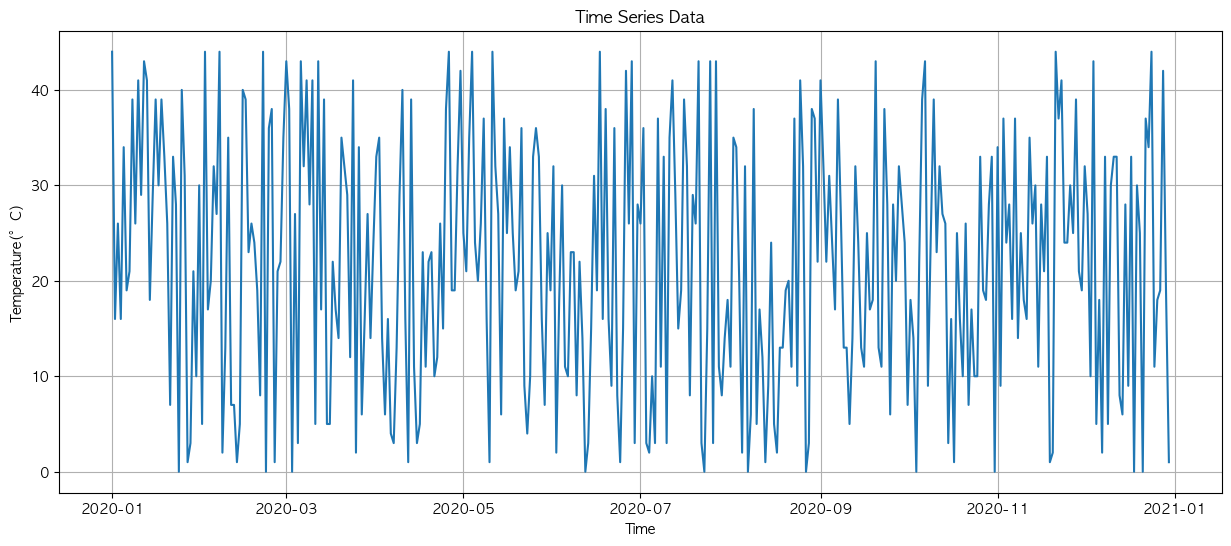

In [164]:
# 날짜 범위 생성 (예: 2020년 1월 1일부터 1년간)
dates = pd.date_range(start="2020-01-01", periods=365, freq="D")
values = np.random.randint(0, 45, size=len(dates))

# 시계열 난수 데이터 생성 (날짜를 인덱스로 설정)
time_series = pd.Series(values, index=dates)

# 생성된 시계열 데이터 출력
display(time_series)

# 시계열 데이터 시각화
plt.figure(figsize=(15, 6))
sns.lineplot(time_series)
plt.xlabel("Time")
plt.ylabel("Temperature(°C)")
plt.title("Time Series Data")
plt.grid(True)

plt.show()

#### 📚 자료 : (1-2)

*  [Time seriese - Wikipeida](https://en.wikipedia.org/wiki/Time_series) : 시계열에 대한 설명
*  [Time Series Analysis: Definition, Types, Techniques, and When It's Used
](https://www.tableau.com/learn/articles/time-series-analysis#examples) : Tableau 사이트에서 설명하는 시계열 데이터

### 1-3 파생 변수 만들기I (도메인 지식 기반)

> **파생 변수를 만들기 전에 주식에 대해서 잠깐 이야기해볼까요?** <br>
평소 주식을 많이 하시나요? 주식은 회사를 대표하는 금융 자산입니다. <br>
회사에서는 주식을 발행하여 개별(개미) 및 기관 투자자에게 판매합니다. <br> 이후, 회사로부터 발생하는 여러 이슈(적자&흑자)들이 투자자들이 가진 주식가격에 영향을 미치게 됩니다. <br>
즉, 회사가 잘되면 주가가 올라가 투자자의 투자금도 함께 상승하게 되는 원리입니다.

#### 📝 설명 : (1-3)
> 제가 앞서 주식에 대해서 먼저 이야기한 이유는 주식과 관련된 기술 및 이론을 설명하기 위함이였습니다. <br>
주식을 올바른 타이밍에 매수하고 매도하기 위해서 오랜 과거부터 여러 기술들이 발전해왔습니다.<br>
**주식을 전략적으로 분석하기 위해 사용하는 여러 기술들을 알아보고, 이를 파생 변수로 만들어보는 실습을 하겠습니다.**

 📖 설명 : 주식 시장 또는 금융 도메인에서 사용하는 여러 기술들을 간략히 알아보고 이해하도록 하겠습니다. <br>
 주식 분석에서 많이 사용하는 이동평균을 바탕으로, 볼린저 밴드(Bollinger Bands), MACD 등을 파생 변수로 추가합니다. <br>
 이외에도 일일수익률과 같은 간단한 개념도 파생 변수로 추가하도록 하겠습니다.

 **우리가 제작할 파생 변수는 아래와 같습니다.**
 - 가격 범위 (Price Range)
 - 평균 가격 (Average Price)
 - 가격 방향 (Price Direction)
 - 일일 투자 수익률 (Daily Return)
 - 이동평균 (Moving Average)
 - 볼린저 밴드 (Bollinger bands)
 - MACD (Moving Average Convergence & Divergence)




#### 👨‍💻 코드 : (1-3)
- 첫번째 파생 변수는 주가의 가격 차이 (변동폭)입니다.
- 가격 차이는 고가 (High) - 저가 (Low)로 간단히 계산할 수 있는 단일 상호작용 파생 변수 입니다.
- 가격의 변동성이 일정 수준 넘어설 때 매매 포지션을 취하는 변동성 돌파 전략 (Volatility Breakout Strategy)에 활용됩니다.
<br>
<br>
$$
가격\,차이 = 고가 - 저가
$$  

In [165]:
# 가격 차이를 구합시다.
OHLCV_data["PriceRange"] = OHLCV_data["High"] - OHLCV_data["Low"]

display_cols = get_display_cols(OHLCV_data)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,13800.0,500
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,205741.0,5715
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,181500.0,6000
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,38650.0,1090
...,...,...,...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31,삼성생명,NaN,900
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31,LG유플러스,NaN,130
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31,NAVER,NaN,15500
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31,현대모비스,NaN,4500


- **다음 파생 변수는 평균 가격입니다.**
- 일 단위로 종목별 평균을 구할 수 있습니다.
- 주가의 전반적인 흐름을 이해하는데 필요한 대푯값입니다.
<br>
<br>
$$
평균 가격 = (시가 + 고가 + 저가 + 종가) / 4
$$  

In [166]:
# 종목의 대푯값인 평균 가격을 구합시다.
OHLCV_data["AveragePrice"] = OHLCV_data[["Open", "High", "Low", "Close"]].mean(axis=1)

display_cols = get_display_cols(OHLCV_data)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000,55425.00
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,13800.0,500,14037.50
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,205741.0,5715,210860.75
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,181500.0,6000,185000.00
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,38650.0,1090,39235.75
...,...,...,...,...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31,삼성생명,NaN,900,69600.00
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31,LG유플러스,NaN,130,10052.50
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31,NAVER,NaN,15500,220500.00
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31,현대모비스,NaN,4500,232875.00


- 이번에는 주가의 방향을 구해볼까요?
- 종가(Close)가 시가(Open)에 비해 어떻게 변화되었는지 간단하게 알아 볼수 있습니다.
- 종가가 시가보다 크면 주가의 방향은 양(1)으로, 반대로 종가가 시가보다 작으면 음(-1)을 표현하도록 하겠습니다.
<br>
<br>

$$
\begin {align}
&if \; \text{종가} > \text{시가} \; \text{Then} \; 1 \\
&Else \; \text{Then} \; -1
\end {align}
$$

In [167]:
# np.where를 사용하여 벡터화 연산으로 성능을 개선합니다. (apply보다 훨씬 빠름)
OHLCV_data['PriceDirection'] = np.where(OHLCV_data['Close'] > OHLCV_data['Open'], 1, -1)

display_cols = get_display_cols(OHLCV_data)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice,PriceDirection
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000,55425.00,-1
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,13800.0,500,14037.50,-1
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,205741.0,5715,210860.75,-1
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,181500.0,6000,185000.00,-1
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,38650.0,1090,39235.75,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31,삼성생명,NaN,900,69600.00,1
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31,LG유플러스,NaN,130,10052.50,-1
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31,NAVER,NaN,15500,220500.00,1
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31,현대모비스,NaN,4500,232875.00,-1



- 주식에서 중요하게 여겨지는 개념이 "복리" 입니다.
- 주식은 복리의 마법이 존재하는 시장입니다. 일일 수익률이 지속적으로 상승한다면 투자 수익금이 기하급수적으로 올라가게 됩니다.
- 자신이 보유한 주식의 일일 수익률을 바탕으로 추후 복리를 계산해 장기적인 미래 수익률을 볼수도 있겠죠.
- 또한, 과거 특정 종목의 일일 수익률을 분석해 인사이트를 얻을 수도 있습니다.
- **파생 변수로 "일일 수익률"을 구해보도록 하겠습니다.**

$$
일일 수익률 = \left(\frac{다음날 종가-현재 종가}{현재 종가}\right) * 100
$$

<br>
<center>or</center>
<br>

$$
일일 수익률 = ((다음날 종가 - 현재 종가) - 1) * 100
$$





In [168]:
# 일일 수익률은 두가지 방법으로 계산할 수 있습니다.
# 첫번째는 수식을 직접 명시하는 방법입니다.
display(
    ((OHLCV_data["Close"] / OHLCV_data["Close"].shift(1)) - 1) * 100
)

0                NaN
1         -74.909420
2        1402.693141
3         -12.311470
4         -78.729315
            ...     
30811     -75.071429
30812     -85.659026
30813    2167.732268
30814       2.643172
30815     -67.510730
Name: Close, Length: 30816, dtype: float64

In [169]:
# 두번째 방법은 pct_change 기능을 이용하는 것입니다.
# pct_change는 행과 행사이의 차이를 구하는 기능입니다.

# 두 방법 모두 결과는 동일합니다.
# 주의: 아래는 전체 데이터에 대해 계산한 것으로, 종목 경계를 무시합니다!
# (올바른 방법은 다음 셀에서 종목별 groupby로 수정합니다.)
OHLCV_data["DailyReturn"] = OHLCV_data["Close"].pct_change() * 100

display_cols = get_display_cols(OHLCV_data)
display(OHLCV_data[display_cols])

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice,PriceDirection,DailyReturn
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000,55425.00,-1,NaN
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,13800.0,500,14037.50,-1,-74.909420
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,205741.0,5715,210860.75,-1,1402.693141
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,181500.0,6000,185000.00,-1,-12.311470
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,38650.0,1090,39235.75,-1,-78.729315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30811,69700,69900,69000,69800,148172,0.010130,032830,2023-07-31,삼성생명,NaN,900,69600.00,1,-75.071429
30812,10090,10120,9990,10010,1088916,-0.007929,032640,2023-07-31,LG유플러스,NaN,130,10052.50,-1,-85.659026
30813,214500,228000,212500,227000,2725703,0.075829,035420,2023-07-31,NAVER,NaN,15500,220500.00,1,2167.732268
30814,234000,234500,230000,233000,179847,0.002151,012330,2023-07-31,현대모비스,NaN,4500,232875.00,-1,2.643172


- **⛔ 만들고 보니 너무 쉽지않나요? 근데 이렇게 구하시면 안됩니다! ⛔**
- 종목(code)컬럼이 존재하기 때문에 종목별로 따로 집계하여 일일 수익률을 구해야합니다. 아래처럼요.

In [170]:
# 올바른 방법: 종목(code)별로 groupby하여 일일 수익률을 계산합니다.
OHLCV_data['DailyReturn'] = (
    OHLCV_data
    .groupby('code')['Close']
    .transform(lambda x: x.pct_change() * 100)
)

- 일일 투자 수익률을 **양수인 경우에는 수익**을 의미하고, **음수인 경우에는 손실**을 나타냅니다.
- 주식 투자 시, 매번 수익을 본다면 복리가 적용되면서 엄청난 이익을 불러오겠죠?

<center><img src='https://lh3.googleusercontent.com/rd-d/ALs6j_GRjIflvx5JSe6Zra3CVqlpp-9dobC4AZtCpfRAQb4JWxzujzPsqMNa5663UFHrpSmSpG9aYz05naHqOYzrrlhBd1OYQMGGKStaNrou1RuHXrsqVGHHWuyV78Iiare1MeMjVXMSJ_dZ7BfumI0BXoSdJjoalbz4eCS_QYx0btrQaZPrkfzfXMOykDnT2O9vWehsYGUWzNtiNTQMLW87Dh8Jvn2FbvDFEMIMb-Dg7KIDNOZa9wM29BoswSLzDT7v14qY2A3dlp3VeN_A3_FsJvSMihRZAW6jT-JKz-ADyTTToQO1OsTcDI0rslTl0FRRpuFfbQDoZ9VHUgl8PCp9MlU3op9EBZPWLizWXsfiN-63m-ZQOgA44r6TVbEgOCwrARuOk4hOjDNNLZYIoJw4BAYsJrxMrS3t9VgAdcPWoRoNiNBqpmt_7BSsG6f9jFSuOm4U3Ci-pIfVMM5LeLn19XJ4ojiDOlM16cLlHeQNdKRzA_Plv0IYpIibCrsNXw8KnXdrQ05Of5a5YSYsJBuj_tAUBnDixBtjAFuTHUPmkcmni76eOh95xpVfOrUdmOEAaXf8x-dV61TUqer6nMPONHJbsinAPUKPm6SgqLh2xRdWEBrzqwv2MDzD-dKiYa-a6uc5c-kD_N_wZQf2b8H3iaHNQZeRdCuLIAyykCMFO1dN5ttIP3LGStSL8GXJ1xan9f6HSVCYUBpWmuYbH66e_6r_sAIv1m-fONrfOxPIDVczGt7KrIGwYrDuk6-_u7VWMpOS6kArJC8dysHYdn4ElCTvG3GwrHd6lDw6jvlC3dB4XEU_ucSFZREyMBQ2uA2H8Ufw9AUTekUTQbS0yG-8aWrYjWR8ACmdxp7R70ZpJpFv2wrrxgArUrPJjPBTsU-pV3FiAirMBriXqWfm6_euY00a50wvbHFVXVOrMidS7HW4yy4vOIClVSUiMgbSvhT-XWuLtRHiWUEOwUviXLshWKZvhXpHXBuZSv3NKk4UnTBo1tL3-nXvtbaNEZyKnLqshvVoy7TteKfjTNsR72tVM_ewO8p_b2eZKEMZwR6KKNw=w1259-h864' width="450"></center>
<center>이미지) "첫 번째 규칙은 절대 잃지 마라. 두 번째 규칙은 첫 번째를 절대로 따라라." -워런 버핏-

- **다음 파생 변수는 이동평균(Moving average)입니다.**
- 주식 투자자들이 종목 분석을 진행할 때 주식 차트라는 것을 보게됩니다.
- 이때 차트에서 이동평균선을 기반으로 많이 추세를 파악합니다. 주로 이평선이라고도 불립니다.
- **이동평균을 중요시하는 이유는 주가의 전반적인 추세를 말끔하게 볼수 있다는 장점이 있습니다.**
- 또한, 이동평균을 바탕으로 파생되는 주식 분석에 중요한 여러 중요한 이론들이 존재합니다.
<br>
<br>
$$
이동평균(SMA_{n}) = \frac{종가_{1}+종가_{2}+종가_{3} +...+종가_{n}}{n}
$$
<br>
<br>
- 위의 식처럼 **이동평균은 특정 기간의 종가의 평균값을 계산한 결과입니다.**
- 이동평균은 크게 **단순 이동평균 (Simple Moving Average, SMA)**와 **지수 이동평균(Exponential Moving Average, EMA)**로 나뉩니다.
- 지수 이동평균은 뒤에서 다시 다뤄보도록 하고, 여기서는 단순 이동평균으로 파생 변수를 만들어 보겠습니다.

In [171]:
# 이동 평균은 rolling 기능을 이용해 쉽게 구할 수 있습니다.
# rolling은 윈도우(기간)을 설정하여 특정 연산을 할수 있습니다.
# window는 몇일 간의 이동 평균을 구할지 설정하는 파라미터입니다.
display("예) 20일간의 종가 합산")
display(OHLCV_data["Close"].rolling(window=20).sum())

'예) 20일간의 종가 합산'

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
30811    4496179.0
30812    3855132.0
30813    4070482.0
30814    4273982.0
30815    3855682.0
Name: Close, Length: 30816, dtype: float64

In [172]:
# mean으로 바꿔주면 20일간의 이동평균이 됩니다.
display("20일간의 이동평균")
display(OHLCV_data["Close"].rolling(window=20).mean())

'20일간의 이동평균'

0              NaN
1              NaN
2              NaN
3              NaN
4              NaN
           ...    
30811    224808.95
30812    192756.60
30813    203524.10
30814    213699.10
30815    192784.10
Name: Close, Length: 30816, dtype: float64

- 이동평균은 주로 5일, 20일, 60일, 120일로 설정하여 분석합니다.
- **보통은 5일, 20일은 "단기 이동평균", 60일은 "중기 이동평균", 120일은 "장기 이동평균"이라 합니다.**
- 중·장기 이동 평균은 단기 적인 주가에 의한 변화가 둔합니다. 이 때문에 주가의 대세를 장기적으로 판단할 수 있습니다.
- 반대로 단기 이동 평균은 시세의 전환을 빠르게 파악할 수 있으므로 주가의 약한 변동에도 민감하게 반응합니다.
- 우리는 파생 변수로 이 모든것을 만들어 보겠습니다. :)

In [173]:
# 5일, 20일, 60일, 120일의 이동평균을 계산합니다.
OHLCV_data["MovingAverage5d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=5).mean())
OHLCV_data["MovingAverage20d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).mean())
OHLCV_data["MovingAverage60d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=60).mean())
OHLCV_data["MovingAverage120d"] = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=120).mean())

In [174]:
# 과거의 종가를 이용해서 이동평균을 구하기 때문에 첫 부분에는 결측치가 만들어지는 것을 볼수 있습니다.
display_cols = get_display_cols(OHLCV_data)
display(OHLCV_data[display_cols].head(30))

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,PriceRange,AveragePrice,PriceDirection,DailyReturn,MovingAverage5d,MovingAverage20d,MovingAverage60d,MovingAverage120d
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,55500.0,1000,55425.00,-1,NaN,NaN,NaN,NaN,NaN
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,13800.0,500,14037.50,-1,NaN,NaN,NaN,NaN,NaN
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,205741.0,5715,210860.75,-1,NaN,NaN,NaN,NaN,NaN
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,181500.0,6000,185000.00,-1,NaN,NaN,NaN,NaN,NaN
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,38650.0,1090,39235.75,-1,NaN,NaN,NaN,NaN,NaN
5,30909,31010,30508,30609,241047,-0.006524,035720,2020-01-02,카카오,30609.0,502,30759.00,-1,NaN,NaN,NaN,NaN,NaN
6,45078,45578,44897,44898,416930,0.002031,003670,2020-01-02,포스코퓨처엠,45353.0,681,45112.75,-1,NaN,NaN,NaN,NaN,NaN
7,121000,121000,118000,118000,556532,-0.020747,005380,2020-01-02,현대자동차,116000.0,3000,119500.00,-1,NaN,NaN,NaN,NaN,NaN
8,252500,253000,245000,245000,32615,-0.029703,097950,2020-01-02,CJ제일제당,241000.0,8000,248875.00,-1,NaN,NaN,NaN,NaN,NaN
9,428000,428500,420500,424000,23211,-0.002353,010130,2020-01-02,고려아연,425500.0,8000,425250.00,-1,NaN,NaN,NaN,NaN,NaN


- **삼성전자 종목을 기준으로 이동평균선을 그려볼까요?**
- 우리 함께 직접 삼성전자 주식을 분석해봅시다.

In [175]:
# 결측치들이 많이 생겼기 때문에 결측치들을 모두 제거해주겠습니다.
ma_cols = ["MovingAverage5d", "MovingAverage20d", "MovingAverage60d", "MovingAverage120d"]

samsung_data = (
    OHLCV_data[OHLCV_data["code"] == "005930"]
    .copy()
    .dropna(subset=ma_cols)
)

In [176]:
# 오늘이 2023-03-01이라고 가정하겠습니다.
# 2023-01-01 ~ 2023-03-01까지의 데이터를 보죠.
samsung_data = samsung_data[(samsung_data["Date"] >= "2023-03-01") & (samsung_data["Date"] <= "2023-03-31")]

# 날짜 형식을 숫자로 변환해야 시각화를 하기 수월합니다.
samsung_data["Date"] = samsung_data["Date"].map(mpdates.date2num)

# 차트를 그리기 위해서 필요한 데이터만 뽑아 보아요.
samsung_data = samsung_data[
    [
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "MovingAverage5d",
        "MovingAverage20d",
        "MovingAverage60d",
        "MovingAverage120d",
    ]
]

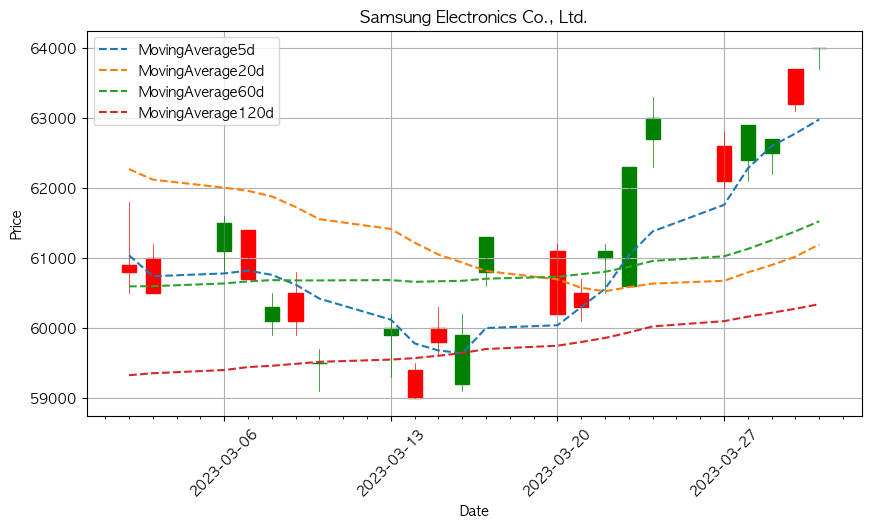

In [177]:
fig, ax = plt.subplots(figsize=(10, 5))

# 아래 함수를 이용해 캔들차트를 그릴 수 있습니다.
candlestick_ohlc(ax, samsung_data.values, width=0.6, colorup="g", colordown="r")

# X 축에 주간 구분선을 추가 하겠습니다.
ax.xaxis.set_major_locator(mpdates.WeekdayLocator(mpdates.MONDAY))
ax.xaxis.set_minor_locator(mpdates.DayLocator())

# 아까 숫자로 변환한 날짜 데이터를 보기 좋게 형식 변환을 합시다.
ax.xaxis.set_major_formatter(mpdates.DateFormatter("%Y-%m-%d"))

# 반복문을 통해 이동평균선을 그려줍니다.
for col in [
    "MovingAverage5d",
    "MovingAverage20d",
    "MovingAverage60d",
    "MovingAverage120d",
]:
    ax.plot(samsung_data["Date"], samsung_data[col], label=col, linestyle="--")


# 필요한 범례들을 작성해 줍시다.
plt.title("Samsung Electronics Co., Ltd.")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)

plt.show()


- 이제 이동평균을 파생 변수로 만들어냈으니, 이에 기반한 여러 기술들을 제작해봅시다.
- **볼린저 밴드(Bollinger bands)는 이동평균을 기준으로 상한(Upper), 하한(Lower) 밴드를 구성하여 추세와 변동성을 파악하는 기술입니다.**
- 1980년대 후반 존 볼린저가 발명하였고, 주식 기술 분석에서 많이 활용되는 보조지표입니다.
- 일반적으로 20일 이동평균에 2배의 표준편차를 더하거나 빼서 구하게 됩니다.

<br>
<br>

$$
상단~볼린저~밴드 = 20일~이동평균 +(k \times 표준편차)
$$

<br>
<br>

$$
하단~볼린저~밴드 = 20일~이동평균 -(k \times 표준편차)
$$

<br>
<br>

- 볼린저 밴드를 계산해보고, 위의 이동평균선과 같이 차트로 만들어 보도록 하겠습니다.

In [178]:
# 표준편차에 대한 상한 및 하한 밴드의 배수 설정
std_multiplier = 2

std = OHLCV_data.groupby("code")["Close"].transform(lambda x: x.rolling(window=20).std())

# 상한은 일반적으로 20일 이동평균에 2배의 표준편차 더하기
# 하한은 일반적으로 20일 이동평균에 2배의 표준편차 빼기
OHLCV_data["UpperBollingerBand"] = OHLCV_data["MovingAverage20d"] + (std_multiplier * std)
OHLCV_data["LowerBollingerBand"] = OHLCV_data["MovingAverage20d"] - (std_multiplier * std)

- **아까와 동일하게 이동평균선에 볼린저 밴드를 추가해서 시각화 해보겠습니다.**
- 이동평균과 볼린저 밴드가 어떤역할을 하는지 이해해봅시다.

In [179]:
# 결측치들이 많이 생겼기 때문에 결측치들을 모두 제거해주겠습니다.
bb_cols = ma_cols + ["LowerBollingerBand", "UpperBollingerBand"]

samsung_data = (
    OHLCV_data[OHLCV_data["code"] == "005930"]
    .copy()
    .dropna(subset=bb_cols)
)

In [180]:
# 오늘이 2023-03-01이라고 가정하겠습니다.
# 2023-01-01 ~ 2023-03-01까지의 데이터를 보죠.
samsung_data = samsung_data[(samsung_data["Date"] >= "2023-03-01") & (samsung_data["Date"] <= "2023-03-31")]

# 날짜 형식을 숫자로 변환해야 시각화를 하기 수월합니다.
samsung_data["Date"] = samsung_data["Date"].map(mpdates.date2num)

# 차트를 그리기 위해서 필요한 데이터만 뽑아 보아요.
samsung_data = samsung_data[
    [
        "Date",
        "Open",
        "High",
        "Low",
        "Close",
        "MovingAverage5d",
        "MovingAverage20d",
        "MovingAverage60d",
        "MovingAverage120d",
        "LowerBollingerBand",
        "UpperBollingerBand",
    ]
]

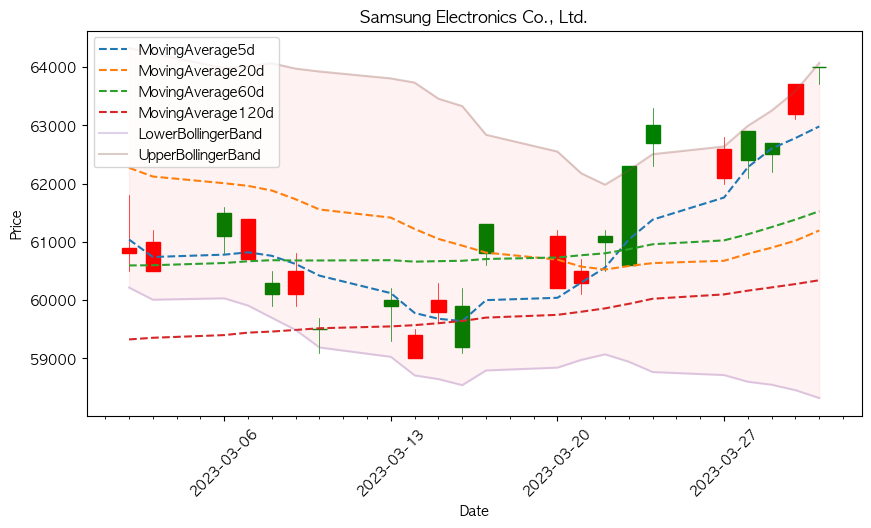

In [181]:
fig, ax = plt.subplots(figsize=(10, 5))

# 아래 함수를 이용해 캔들차트를 그릴 수 있습니다.
candlestick_ohlc(ax, samsung_data.values, width=0.6, colorup="g", colordown="r")

# X 축에 주간 구분선을 추가 하겠습니다.
ax.xaxis.set_major_locator(mpdates.WeekdayLocator(mpdates.MONDAY))
ax.xaxis.set_minor_locator(mpdates.DayLocator())

# 아까 숫자로 변환한 날짜 데이터를 보기 좋게 형식 변환을 합시다.
ax.xaxis.set_major_formatter(mpdates.DateFormatter("%Y-%m-%d"))

# 반복문을 통해 이동평균선을 그려줍니다.
for col in [
    "MovingAverage5d",
    "MovingAverage20d",
    "MovingAverage60d",
    "MovingAverage120d",
]:
    ax.plot(samsung_data["Date"], samsung_data[col], label=col, linestyle="--")

for col in [
    "LowerBollingerBand",
    "UpperBollingerBand",
]:
    ax.plot(samsung_data["Date"], samsung_data[col], label=col, alpha=0.3)

# 볼린저 밴드를 위해 투명도를 가진 색을 채워놓도록 하겠습니다.
plt.fill_between(
    samsung_data["Date"],
    samsung_data["LowerBollingerBand"],
    samsung_data["UpperBollingerBand"],
    color="red",
    alpha=0.05,
)


# 필요한 범례들을 작성해 줍시다.
plt.title("Samsung Electronics Co., Ltd.")
plt.xlabel("Date")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.legend()

plt.show()


- 볼린저 밴드까지 완성하여 시각화를 하니 실제 주식 차트에서 보는 것과 유사해 보입니다.
- 볼린저 밴드의 영역이 좁으면 주가의 변동성이 낮다는 것을 의미하고, 넓으면 변동성이 높다는 것을 의미합니다.
- 이외에도 주가의 추세를 확인하는데 도움을 주는 지표이며, 아래 첨부한 관련 참고자료를 보시는 것을 추천드립니다.

- **이번엔 MACD (Moving Average Convergence & Divergence)라고 불리는 이동평균 수렴&확산 지수도 구해보겠습니다.**
- MACD도 이동평균에서 파생된 기술입니다. "엠에이씨디" 및 "맥디" 라고 발음합니다.
- 장기 지수이동평균과 단기 지수이동평균의 차이를 통해 계산됩니다.
- 주로 주가 추세의 힘과 방향성을 파악하여 매매신호를 잡으려는 목적으로 활용됩니다.
<br>
<br>
$$
MACD = 12일~지수이동평균 - 26일~지수이동평균
$$

- MACD를 계산하려면 지수 이동평균을 알아야합니다.
- 지수 이동평균(Exponential Moving Average, EMA)은 시계열 데이터에서 최근 관측치에 높은 가중치를 주고, 과거 관측치에는 낮은 가중치를 주어 이동평균을 차등 계산하는 방식입니다.
- 12일 & 26일 지수 이동평균도 파생 변수로 함께 추가하도록 하죠.
<br>
<br>
$$
EMA_{t} = \alpha \times Close_{t} + (1 - \alpha) \times EMA_{t-1}
$$


In [182]:
# .ewm를 이용하면 데이터프레임에서 지수가중함수를 손쉽게 제어할 수 있습니다.
# 12일, 26일 각각의 지수가중함수를 구하도록 하겠습니다.
# 주의: 종목별(code)로 groupby하여 계산해야 종목 경계가 섞이지 않습니다!
OHLCV_data['ShortEMA'] = OHLCV_data.groupby("code")["Close"].transform(
    lambda x: x.ewm(span=12, adjust=False).mean()
)
OHLCV_data['LongEMA'] = OHLCV_data.groupby("code")["Close"].transform(
    lambda x: x.ewm(span=26, adjust=False).mean()
)

# 지수가중함수의 차를 구해 MACD를 완성시킵니다.
OHLCV_data['MACD'] = OHLCV_data['ShortEMA'] - OHLCV_data['LongEMA']

- 원래 주식의 기술 분석에서는 MACD와 함께 신호(Signal)값을 추가하여 분석을 해야합니다.
- 하지만 이번 실습에서는 MACD만을 파생 변수로 사용하도록 하겠습니다.
- 더 깊은 정보를 원하신다면 아래 자료를 참고해주세요.


In [183]:
# 짜잔! 도메인 지식에 기반한 여러 파생 변수들이 만들어졌습니다!
display_cols = get_display_cols(OHLCV_data)

display(OHLCV_data[display_cols].head(10))
display(display_cols)

,Open,High,Low,Close,Volume,Change,code,Date,company,Target,...,DailyReturn,MovingAverage5d,MovingAverage20d,MovingAverage60d,MovingAverage120d,UpperBollingerBand,LowerBollingerBand,ShortEMA,LongEMA,MACD
0,55500,56000,55000,55200,12993228,-0.010753,005930,2020-01-02,삼성전자,55500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55200.0,55200.0,0.0
1,14200,14300,13800,13850,1398146,-0.024648,032640,2020-01-02,LG유플러스,13800.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13850.0,13850.0,0.0
2,213361,213837,208122,208123,110030,-0.024550,011170,2020-01-02,롯데케미칼,205741.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,208123.0,208123.0,0.0
3,187500,188000,182000,182500,300640,-0.021448,035420,2020-01-02,NAVER,181500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,182500.0,182500.0,0.0
4,39738,39738,38648,38819,170781,-0.021131,000100,2020-01-02,유한양행,38650.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38819.0,38819.0,0.0
5,30909,31010,30508,30609,241047,-0.006524,035720,2020-01-02,카카오,30609.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30609.0,30609.0,0.0
6,45078,45578,44897,44898,416930,0.002031,003670,2020-01-02,포스코퓨처엠,45353.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44898.0,44898.0,0.0
7,121000,121000,118000,118000,556532,-0.020747,005380,2020-01-02,현대자동차,116000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118000.0,118000.0,0.0
8,252500,253000,245000,245000,32615,-0.029703,097950,2020-01-02,CJ제일제당,241000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,245000.0,245000.0,0.0
9,428000,428500,420500,424000,23211,-0.002353,010130,2020-01-02,고려아연,425500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,424000.0,424000.0,0.0


['Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'Change',
 'code',
 'Date',
 'company',
 'Target',
 'PriceRange',
 'AveragePrice',
 'PriceDirection',
 'DailyReturn',
 'MovingAverage5d',
 'MovingAverage20d',
 'MovingAverage60d',
 'MovingAverage120d',
 'UpperBollingerBand',
 'LowerBollingerBand',
 'ShortEMA',
 'LongEMA',
 'MACD']

#### 📚 자료 : (1-3)

*  [주식의 기원, 유래, 기본원리](https://m.blog.naver.com/chochila/40149313237
) : 주식 기본 설명
*  [주식 단어 모음집](https://blog.hyosung.com/5006) : 주식 기초 단어 익히기
*  [이동평균선의 이해](https://www.hi-ib.com/systemtrade/st02090602.jsp) : 이동평균선을 이해하고 이에따른 투자전략을 세우는 자료
*  [볼린저 밴드의 이해](https://m.blog.naver.com/rmsgud2007/222316784405) : 볼린저 밴드를 깊게 이해할 수 있는 자료
*  [MACD 위키백과](https://namu.wiki/w/MACD) : MACD 설명 자료
*  [지수가중함수](https://wikidocs.net/152787) : Pandas의 지수가중함수에 대해 설명



### 1-4 파생 변수 만들기II (상장법인정보 기반)

> **도메인 지식에 기반해서 파생 변수를 만들어봤으니 이번에는 상장법인정보를 기반해 파생 변수도 만들어볼게요!**<br>
- 상장법인정보에는 **업종(industry), 주요 제품(Products), 상장일(listing_date), 결산월(closing_month), 지역(region)**이 존재합니다.

#### 📝 설명 : (1-4)
> 이번 파생 변수 만들기 II에서는 크게 2가지의 파생 변수를 만들겠습니다. <br>
**"통계 기반 파생 변수"와 "시간관련 파생 변수"**는 도메인 지식과 관련된 변수라기 보다는 기존의 변수를 분할하거나 계산하여 제작할 수 있습니다. <br>
도메인 지식과 연관되어 있지 않아 어렵지 않으니 잘 따라와보세요!

#### 👨‍💻 코드 : (1-4)
- 통계 기반 파생 변수는 변수들의 통계값을 이용해 제작하게 됩니다.
- 주로 대푯값을 이용하기 때문에 관측값의 상대적 위치를 잘 파악할 수 있는 장점이 있습니다.
- **업종(industry)을 기준으로 Open (시가), High (고가), Low (저가), Close (종가), Volume (거래량) 컬럼의 일별 평균과 중앙값을 파생 변수로 추가할게요!**

In [184]:
# 상장법인정보를 기반해 파생 변수를 만들어보죠!
# 아까 제작한 도메인 지식 기반 파생 변수는 출력하지 않을게요.
except_cols_section4 = [
    "DailyReturn", "MovingAverage5d", "MovingAverage20d",
    "MovingAverage60d", "MovingAverage120d", "LowerBollingerBand",
    "UpperBollingerBand", "ShortEMA", "LongEMA", "MACD", "code",
    "PriceRange", "AveragePrice", "PriceDirection", "products"
]
display_cols = get_display_cols(OHLCV_data, except_cols_section4)

OHLCV_data[display_cols].head(10)

,Open,High,Low,Close,Volume,Change,Date,company,industry,listing_date,closing_month,region,Target
0,55500,56000,55000,55200,12993228,-0.010753,2020-01-02,삼성전자,반도체 제조업,1975-06-11,12월,경기,55500.0
1,14200,14300,13800,13850,1398146,-0.024648,2020-01-02,LG유플러스,전기통신업,2000-07-27,12월,서울,13800.0
2,213361,213837,208122,208123,110030,-0.024550,2020-01-02,롯데케미칼,기초화학물질 제조업,1976-12-01,12월,서울,205741.0
3,187500,188000,182000,182500,300640,-0.021448,2020-01-02,NAVER,소프트웨어 개발업,2008-11-28,12월,경기,181500.0
4,39738,39738,38648,38819,170781,-0.021131,2020-01-02,유한양행,의약품 제조업,1962-11-01,12월,서울,38650.0
5,30909,31010,30508,30609,241047,-0.006524,2020-01-02,카카오,소프트웨어 개발업,2017-07-10,12월,제주,30609.0
6,45078,45578,44897,44898,416930,0.002031,2020-01-02,포스코퓨처엠,일차전지 및 축전지 제조업,2003-04-22,12월,경북,45353.0
7,121000,121000,118000,118000,556532,-0.020747,2020-01-02,현대자동차,자동차 제조업,1974-06-28,12월,서울,116000.0
8,252500,253000,245000,245000,32615,-0.029703,2020-01-02,CJ제일제당,식품 제조업,2007-09-05,12월,서울,241000.0
9,428000,428500,420500,424000,23211,-0.002353,2020-01-02,고려아연,비철금속 제련업,1990-03-08,12월,서울,425500.0


In [185]:
# OHLCV컬럼 모두 업종별로 일일 평균, 중앙값을 집계해보겠습니다.
# 일별, 업종별로 집계를 해야하기 때문에 두개의 변수(Date, industry)가 집계요소로 들어갑니다.

# 반복적인 merge를 루프로 통합하여 코드 중복을 제거합니다.
ohlcv_target_cols = ["Open", "High", "Low", "Close", "Volume"]

for col in ohlcv_target_cols:
    stats = OHLCV_data.groupby(["Date", "industry"])[col].agg(["mean", "median"])
    stats.columns = [f"{col}Mean", f"{col}Median"]
    OHLCV_data = pd.merge(OHLCV_data, stats, how="inner", on=["industry", "Date"])

In [186]:
display_cols = get_display_cols(OHLCV_data, except_cols_section4)

OHLCV_data[display_cols].head(10)

,Open,High,Low,Close,Volume,Change,Date,company,industry,listing_date,...,OpenMean,OpenMedian,HighMean,HighMedian,LowMean,LowMedian,CloseMean,CloseMedian,VolumeMean,VolumeMedian
0,55500,56000,55000,55200,12993228,-0.010753,2020-01-02,삼성전자,반도체 제조업,1975-06-11,...,75750.000000,75750.0,76100.000000,76100.0,74550.000000,74550.0,74950.000000,74950.0,7.667649e+06,7667649.0
1,14200,14300,13800,13850,1398146,-0.024648,2020-01-02,LG유플러스,전기통신업,2000-07-27,...,27433.000000,26950.0,27495.333333,26950.0,26900.000000,26700.0,26974.666667,26700.0,1.142754e+06,1398146.0
2,213361,213837,208122,208123,110030,-0.024550,2020-01-02,롯데케미칼,기초화학물질 제조업,1976-12-01,...,267180.500000,267180.5,267418.500000,267418.5,260811.000000,260811.0,261061.500000,261061.5,1.247630e+05,124763.0
3,187500,188000,182000,182500,300640,-0.021448,2020-01-02,NAVER,소프트웨어 개발업,2008-11-28,...,109204.500000,109204.5,109505.000000,109505.0,106254.000000,106254.0,106554.500000,106554.5,2.708435e+05,270843.5
4,39738,39738,38648,38819,170781,-0.021131,2020-01-02,유한양행,의약품 제조업,1962-11-01,...,274711.666667,154591.0,278432.666667,156299.0,269288.333333,150320.0,271940.000000,153740.0,3.238423e+05,170781.0
5,30909,31010,30508,30609,241047,-0.006524,2020-01-02,카카오,소프트웨어 개발업,2017-07-10,...,109204.500000,109204.5,109505.000000,109505.0,106254.000000,106254.0,106554.500000,106554.5,2.708435e+05,270843.5
6,45078,45578,44897,44898,416930,0.002031,2020-01-02,포스코퓨처엠,일차전지 및 축전지 제조업,2003-04-22,...,138554.000000,138554.0,139048.500000,139048.5,135771.000000,135771.0,136016.500000,136016.5,3.037085e+05,303708.5
7,121000,121000,118000,118000,556532,-0.020747,2020-01-02,현대자동차,자동차 제조업,1974-06-28,...,82550.000000,82550.0,82650.000000,82650.0,80150.000000,80150.0,80250.000000,80250.0,9.557805e+05,955780.5
8,252500,253000,245000,245000,32615,-0.029703,2020-01-02,CJ제일제당,식품 제조업,2007-09-05,...,252500.000000,252500.0,253000.000000,253000.0,245000.000000,245000.0,245000.000000,245000.0,3.261500e+04,32615.0
9,428000,428500,420500,424000,23211,-0.002353,2020-01-02,고려아연,비철금속 제련업,1990-03-08,...,428000.000000,428000.0,428500.000000,428500.0,420500.000000,420500.0,424000.000000,424000.0,2.321100e+04,23211.0


- 이번엔 시간관련 파생 변수에요.
- 시간과 관련된 컬럼은 주가가 생성된 날짜를 나타내는 Date컬럼과 상장일을 나타내는 listing_date, 그리고 결산월인 closing_month 입니다.
- 하나하나 변수를 같이 제작해봅시다!

In [187]:
# Date, listing_date컬럼은 "2020-01-01" 형태로 되어있어요.
# 이걸 컴퓨터가 인식할 수 있도록 년,월,일 정수 컬럼으로 나눠서 표현해볼게요.

# Date컬럼이 문자열이거나 object타입일 수 있으니 datetime으로 변환 후 년/월/일 추출
OHLCV_data["Date"] = pd.to_datetime(OHLCV_data["Date"], errors="coerce")
OHLCV_data["DateYear"] = OHLCV_data["Date"].dt.year
OHLCV_data["DateMonth"] = OHLCV_data["Date"].dt.month
OHLCV_data["DateDay"] = OHLCV_data["Date"].dt.day

# listing_date컬럼도 datetime으로 변환 후 년/월/일 추출
OHLCV_data["listing_date"] = pd.to_datetime(OHLCV_data["listing_date"], errors="coerce")
OHLCV_data["ListingDateYear"] = OHLCV_data["listing_date"].dt.year
OHLCV_data["ListingDateMonth"] = OHLCV_data["listing_date"].dt.month
OHLCV_data["ListingDateDay"] = OHLCV_data["listing_date"].dt.day

In [188]:
# closing_month컬럼은 "12월" 형태이기 때문에 "월"을 빼고 정수만 남기도록 할게요.
OHLCV_data["ClosingMonthInt"] = OHLCV_data["closing_month"].str.replace('월', '').astype(int)

In [189]:
# 시간관련 파생 변수를 출력해볼까요?
display(OHLCV_data[
    ["Date", "listing_date", "closing_month",
     "DateYear", "DateMonth", "DateDay",
     "ListingDateYear", "ListingDateMonth",
     "ListingDateDay", "ClosingMonthInt"
     ]
])

,Date,listing_date,closing_month,DateYear,DateMonth,DateDay,ListingDateYear,ListingDateMonth,ListingDateDay,ClosingMonthInt
0,2020-01-02,1975-06-11,12월,2020,1,2,1975,6,11,12
1,2020-01-02,2000-07-27,12월,2020,1,2,2000,7,27,12
2,2020-01-02,1976-12-01,12월,2020,1,2,1976,12,1,12
3,2020-01-02,2008-11-28,12월,2020,1,2,2008,11,28,12
4,2020-01-02,1962-11-01,12월,2020,1,2,1962,11,1,12
...,...,...,...,...,...,...,...,...,...,...
30811,2023-07-31,2010-05-12,12월,2023,7,31,2010,5,12,12
30812,2023-07-31,2000-07-27,12월,2023,7,31,2000,7,27,12
30813,2023-07-31,2008-11-28,12월,2023,7,31,2008,11,28,12
30814,2023-07-31,1989-07-25,12월,2023,7,31,1989,7,25,12


### 1-5 데이터 인코딩 및 결측치 정리

>**이번 챕터에서는 파생 변수를 만드는 것에 초점이 맞추어져 있습니다.**<br>
**범주형 변수의 여러 인코딩 방법을 간단하게 실습해보고, 결측치도 빠르게 처리하도록 하겠습니다.**




#### 📝 설명 : (1-5)
> 3가지 방법의 범주형 변수 인코딩 기법을 실습해보겠습니다. <br>
파생 변수를 생성하면서 불가피하게 만들어진 결측값은 모두 제거하도록 하겠습니다.

#### 👨‍💻 코드 : (1-5)
- Label Encoding은 각 범주를 정수와 1:1로 매칭해 표현하는 방법입니다.
- 하나의 변수에 모든 범주를 표현할 수 있기 때문에 메모리 및 연산에 효율적입니다.
- **업종(industry), 주요제품(products), 지역(region)을 Label Encoding 해봅시다.**
```
주의) Label Encoding은 알고리즘에 따라 순서 의미를 가지지 않는 변수에 부정적 영향을 미칠수도 있습니다.
이때문에 주의해서 사용해야 합니다. (대체제: 원-핫인코딩)
````

In [190]:
# sklearn에서 제공하는 LabelEncoder를 활용합시다.
label_encoder = LabelEncoder()

OHLCV_data["LEncodedIndustry"] = label_encoder.fit_transform(OHLCV_data["industry"])
OHLCV_data["LEncodedProducts"] = label_encoder.fit_transform(OHLCV_data["products"])
OHLCV_data["LEncodedRegion"] = label_encoder.fit_transform(OHLCV_data["region"])

In [191]:
# Label Encoding 결과를 출력해 봅시다.
OHLCV_data[["industry", "products", "region", "LEncodedIndustry", "LEncodedProducts", "LEncodedRegion"]]

,industry,products,region,LEncodedIndustry,LEncodedProducts,LEncodedRegion
0,반도체 제조업,"메모리반도체, 시스템LSI",경기,3,5,0
1,전기통신업,"이동통신, IPTV",서울,16,24,2
2,기초화학물질 제조업,석유화학제품,서울,2,12,2
3,소프트웨어 개발업,"인터넷 검색, 커머스",경기,7,26,0
4,의약품 제조업,"의약품, 건강기능식품",서울,11,22,2
...,...,...,...,...,...,...
30811,생명보험업,"생명보험, 자산운용",서울,5,9,2
30812,전기통신업,"이동통신, IPTV",서울,16,24,2
30813,소프트웨어 개발업,"인터넷 검색, 커머스",경기,7,26,0
30814,자동차 부품 제조업,"자동차 모듈, 부품",서울,13,27,2


- **Frequency Encoding은 범주의 빈도 값으로 인코딩하는 방식입니다.**
- 빈도가 높을수록 높은 정숫값을, 낮을수록 낮은 정숫값을 부여받게 됩니다.
- **업종(industry)에 적용하여 빈도가 높은 업종과, 낮은 업종을 구분할 수 있도록 해보겠습니다.**

In [192]:
frequency_encoder = OHLCV_data["industry"].value_counts()
OHLCV_data['FEncodedIndustry'] = OHLCV_data['industry'].map(frequency_encoder)

In [193]:
# Frequency Encoding 결과를 출력해 봅시다.
OHLCV_data[["industry", "FEncodedIndustry"]]

,industry,FEncodedIndustry
0,반도체 제조업,1772
1,전기통신업,2658
2,기초화학물질 제조업,1772
3,소프트웨어 개발업,1772
4,의약품 제조업,2658
...,...,...
30811,생명보험업,886
30812,전기통신업,2658
30813,소프트웨어 개발업,1772
30814,자동차 부품 제조업,886


- **업종(industry)과 종가(Close)를 이용한 Target Encoding 실습입니다.**
- Target Encoding은 특정(타겟) 변수를 평균으로 인코딩하는 방식입니다.
- **업종과 관련있는 종가를 타겟 변수로 설정하고 인코딩을 해보도록 하겠습니다.**

In [194]:
# 각 업종별 종가의 평균 계산
target_encoder = OHLCV_data.groupby("industry")["Close"].mean()
OHLCV_data["TEncodedIndustry"] = OHLCV_data['industry'].map(target_encoder)

In [195]:
# Target Encoding 결과를 출력해 봅시다.
OHLCV_data[["industry", "Close", "TEncodedIndustry"]]

,industry,Close,TEncodedIndustry
0,반도체 제조업,55200,84722.234763
1,전기통신업,13850,30156.035741
2,기초화학물질 제조업,208123,431006.604966
3,소프트웨어 개발업,182500,180979.958804
4,의약품 제조업,38819,460699.584274
...,...,...,...
30811,생명보험업,69800,66268.002257
30812,전기통신업,10010,30156.035741
30813,소프트웨어 개발업,227000,180979.958804
30814,자동차 부품 제조업,233000,234457.674944


- **이전에 파생 변수를 제작하면서 불가피하게 생성된 결측치는 모두 제거하도록 하겠습니다.**<br>

In [196]:
# 결측치 모두 제거
OHLCV_data.dropna(inplace=True)

In [197]:
# OHLCV의 0이 되는 이상치 및 결측치는 모두 제거
OHLCV_data = OHLCV_data[(OHLCV_data[["Open", "High", "Low", "Close", "Volume", "Change"]] != 0).all(axis=1)]

- **이제 모든 파생 변수를 만들었습니다!!!**
- 학습에 불필요한 컬럼은 제거해보도록 합시다.
- 거의 다 왔습니다.

In [198]:
OHLCV_data.drop([
    "Date", "company", "industry",
    "products", "listing_date", "closing_month",
    "region"
    ], axis=1, inplace=True)

OHLCV_data.reset_index(drop=True, inplace=True)

- 학습에 필요한 데이터들이 모두 완성되었습니다!!!

In [199]:
OHLCV_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Change', 'code', 'Target',
       'PriceRange', 'AveragePrice', 'PriceDirection', 'DailyReturn',
       'MovingAverage5d', 'MovingAverage20d', 'MovingAverage60d',
       'MovingAverage120d', 'UpperBollingerBand', 'LowerBollingerBand',
       'ShortEMA', 'LongEMA', 'MACD', 'OpenMean', 'OpenMedian', 'HighMean',
       'HighMedian', 'LowMean', 'LowMedian', 'CloseMean', 'CloseMedian',
       'VolumeMean', 'VolumeMedian', 'DateYear', 'DateMonth', 'DateDay',
       'ListingDateYear', 'ListingDateMonth', 'ListingDateDay',
       'ClosingMonthInt', 'LEncodedIndustry', 'LEncodedProducts',
       'LEncodedRegion', 'FEncodedIndustry', 'TEncodedIndustry'],
      dtype='str')

In [200]:
OHLCV_data.head(10)

,Open,High,Low,Close,Volume,Change,code,Target,PriceRange,AveragePrice,...,DateDay,ListingDateYear,ListingDateMonth,ListingDateDay,ClosingMonthInt,LEncodedIndustry,LEncodedProducts,LEncodedRegion,FEncodedIndustry,TEncodedIndustry
0,100500,101000,99400,99400,1084453,-0.034951,005380,100000.0,1600,100075.00,...,25,1974,6,28,12,14,28,2,1772,124990.829571
1,27150,27300,26800,26850,1118524,-0.028933,086790,27550.0,500,27025.00,...,25,2005,12,1,12,1,18,2,3544,33782.807562
2,163831,166212,161926,162402,130607,-0.022923,011170,163831.0,4286,163592.75,...,25,1976,12,1,12,2,12,2,1772,431006.604966
3,287000,293500,281000,286000,921229,-0.001745,034730,292000.0,12500,286875.00,...,25,1991,12,17,12,20,30,2,1772,154710.472912
4,55897,56600,54895,55096,900258,-0.028324,035720,55096.0,1705,55622.00,...,25,2017,7,10,12,7,6,5,1772,180979.958804
5,33900,34200,33750,33750,1908667,-0.032951,105560,34800.0,450,33900.00,...,25,2008,10,10,12,1,18,2,3544,33782.807562
6,109000,110500,107000,107500,228486,-0.031532,139480,107500.0,3500,108500.00,...,25,2011,6,10,12,18,4,2,886,128285.553047
7,115000,117500,114000,116000,639728,-0.016949,028260,116500.0,3500,115625.00,...,25,2015,9,15,12,19,3,2,886,116555.643341
8,29700,29700,29300,29300,1754512,-0.029801,055550,29700.0,400,29500.00,...,25,2001,9,10,12,1,19,2,3544,33782.807562
9,131357,136276,129389,131849,1314332,-0.018316,096770,133817.0,6887,132217.75,...,25,2007,7,25,12,6,10,2,886,187808.707675
